In [36]:
# Global imports
import os
import numpy as np
import pandas as pd
import imageio
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, LeakyReLU, MaxPooling2D, Flatten, Dense
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import tensorflow_addons as tfa

In [37]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [38]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [39]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [40]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


In [41]:
# mport train
df_train = pd.read_csv('d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/train_split_Depression_AVEC2017.csv')
df_test = pd.read_csv('d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/test_split_Depression_AVEC2017.csv')
df_test_full = pd.read_csv('d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/full_test_split.csv')
df_dev = pd.read_csv('d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/dev_split_Depression_AVEC2017.csv')

In [42]:
# See head
df_dev.head()

,Participant_ID,PHQ8_Binary,PHQ8_Score,Gender,PHQ8_NoInterest,PHQ8_Depressed,PHQ8_Sleep,PHQ8_Tired,PHQ8_Appetite,PHQ8_Failure,PHQ8_Concentrating,PHQ8_Moving
0,302,0,4,1,1,1,0,1,0,1,0,0
1,307,0,4,0,0,1,0,1,0,2,0,0
2,331,0,8,1,1,1,1,1,1,1,1,1
3,335,1,12,0,1,1,3,2,3,1,1,0
4,346,1,23,0,2,3,3,3,3,3,3,3


In [43]:
df_test['Participant_ID'] = df_test['participant_ID']
df_test.drop('participant_ID', axis=1, inplace=True)

In [44]:
# Check if all data seems ok
print(df_train.shape[0], df_test_full.shape[0], df_dev.shape[0], df_train.shape[0]+ df_test_full.shape[0]+ df_dev.shape[0])

107 47 35 189


In [45]:
import os
import imageio
import pandas as pd
import numpy as np

def load_spectrogram(df):
    # Define root path of data
    root_path = 'd:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data'  # Replace with your root path

    # Add the column for spectrogram if it doesn't exist
    if 'Spectrogram' not in df.columns:
        # Define the shape of the fixed tensor
        tensor_shape = (292, 252, 3)  # Example shape (height, width, channels)

        # Create a fixed tensor of zeros with the desired shape
        fixed_tensor = np.zeros(tensor_shape, dtype=np.uint8)  # Adjust dtype as needed

        # Initialize the 'Spectrogram' column with the fixed tensor
        df['Spectrogram'] = [fixed_tensor.copy() for _ in range(len(df))]

    # Handle missing values in 'Participant_ID' column
    df['Participant_ID'] = pd.to_numeric(df['Participant_ID'], errors='coerce')

    # Iterate over the dataframe to add the image information
    for index, row in df.iterrows():
        if not pd.isnull(row['Participant_ID']):  # Check if Participant_ID is not NaN
            participant_id = str(int(row['Participant_ID']))
            folder_path = os.path.join(root_path, str(participant_id) + '_P')

            if os.path.isdir(folder_path):
                image_path = os.path.join(folder_path, 'resized_spectrogram_preprocessed_' + str(participant_id) + '_AUDIO.jpg')  # Replace with your image name
                if os.path.isfile(image_path):
                    image = imageio.imread(image_path)
                    df.at[index, 'Spectrogram'] = image
                else:
                    print(f"Image file not found at path {image_path}. Skipping...")
            else:
                print(f"Folder not found at path {folder_path}. Skipping...")
            
    return df


In [46]:

df_test = load_spectrogram(df_test)
# Define root path of data


Image file not found at path d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\301_P\resized_spectrogram_preprocessed_301_AUDIO.jpg. Skipping...
Image file not found at path d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\306_P\resized_spectrogram_preprocessed_306_AUDIO.jpg. Skipping...
Image file not found at path d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\308_P\resized_spectrogram_preprocessed_308_AUDIO.jpg. Skipping...
Image file not found at path d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\309_P\resized_spectrogram_preprocessed_309_AUDIO.jpg. Skipping...
Image file not found at path d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\311_P\resized_spectrogram_preprocessed_311_AUDIO.jpg. Skipping...
Image file not found at path d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\314_P\resized_spectrogram_preprocessed_314_AUDIO.jpg. Skipping...
Image file not found at path d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\323_P\resized_spectrogram_prep

C:\Users\herna\AppData\Local\Temp\ipykernel_30556\2803068170.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_path)


In [47]:
df_test_full = load_spectrogram(df_test_full)

Image file not found at path d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\301_P\resized_spectrogram_preprocessed_301_AUDIO.jpg. Skipping...
Image file not found at path d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\306_P\resized_spectrogram_preprocessed_306_AUDIO.jpg. Skipping...
Image file not found at path d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\308_P\resized_spectrogram_preprocessed_308_AUDIO.jpg. Skipping...
Image file not found at path d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\309_P\resized_spectrogram_preprocessed_309_AUDIO.jpg. Skipping...
Image file not found at path d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\311_P\resized_spectrogram_preprocessed_311_AUDIO.jpg. Skipping...
Image file not found at path d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\314_P\resized_spectrogram_preprocessed_314_AUDIO.jpg. Skipping...
Image file not found at path d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\323_P\resized_spectrogram_prep

C:\Users\herna\AppData\Local\Temp\ipykernel_30556\2803068170.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_path)


In [48]:
x_test = df_test['Spectrogram']
y_test = df_test_full['PHQ_Binary']

In [49]:
df_train = load_spectrogram(df_train)

Image file not found at path d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\303_P\resized_spectrogram_preprocessed_303_AUDIO.jpg. Skipping...
Image file not found at path d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\304_P\resized_spectrogram_preprocessed_304_AUDIO.jpg. Skipping...
Image file not found at path d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\305_P\resized_spectrogram_preprocessed_305_AUDIO.jpg. Skipping...
Image file not found at path d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\310_P\resized_spectrogram_preprocessed_310_AUDIO.jpg. Skipping...
Image file not found at path d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\312_P\resized_spectrogram_preprocessed_312_AUDIO.jpg. Skipping...
Image file not found at path d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\313_P\resized_spectrogram_preprocessed_313_AUDIO.jpg. Skipping...
Image file not found at path d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\315_P\resized_spectrogram_prep

In [50]:
df_dev.head()

,Participant_ID,PHQ8_Binary,PHQ8_Score,Gender,PHQ8_NoInterest,PHQ8_Depressed,PHQ8_Sleep,PHQ8_Tired,PHQ8_Appetite,PHQ8_Failure,PHQ8_Concentrating,PHQ8_Moving
0,302,0,4,1,1,1,0,1,0,1,0,0
1,307,0,4,0,0,1,0,1,0,2,0,0
2,331,0,8,1,1,1,1,1,1,1,1,1
3,335,1,12,0,1,1,3,2,3,1,1,0
4,346,1,23,0,2,3,3,3,3,3,3,3


In [51]:
df_dev = load_spectrogram(df_dev)

Image file not found at path d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\302_P\resized_spectrogram_preprocessed_302_AUDIO.jpg. Skipping...
Image file not found at path d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\307_P\resized_spectrogram_preprocessed_307_AUDIO.jpg. Skipping...
Image file not found at path d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\331_P\resized_spectrogram_preprocessed_331_AUDIO.jpg. Skipping...
Image file not found at path d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\335_P\resized_spectrogram_preprocessed_335_AUDIO.jpg. Skipping...
Image file not found at path d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\346_P\resized_spectrogram_preprocessed_346_AUDIO.jpg. Skipping...
Image file not found at path d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\367_P\resized_spectrogram_preprocessed_367_AUDIO.jpg. Skipping...
Image file not found at path d:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/data\377_P\resized_spectrogram_prep

In [52]:
df_dev.head()

,Participant_ID,PHQ8_Binary,PHQ8_Score,Gender,PHQ8_NoInterest,PHQ8_Depressed,PHQ8_Sleep,PHQ8_Tired,PHQ8_Appetite,PHQ8_Failure,PHQ8_Concentrating,PHQ8_Moving,Spectrogram
0,302,0,4,1,1,1,0,1,0,1,0,0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
1,307,0,4,0,0,1,0,1,0,2,0,0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
2,331,0,8,1,1,1,1,1,1,1,1,1,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
3,335,1,12,0,1,1,3,2,3,1,1,0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
4,346,1,23,0,2,3,3,3,3,3,3,3,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


In [53]:
df_train.iloc[[1]]['Spectrogram'][1].shape

(292, 252, 3)

In [54]:
depressed_count = df_train['PHQ8_Depressed'].sum()
non_depressed_count = len(df_train) - depressed_count

print("Number of depressed instances:", depressed_count)
print("Number of non-depressed instances:", non_depressed_count)

Number of depressed instances: 86
Number of non-depressed instances: 21


In [55]:
df_train[df_train['PHQ8_Depressed'] == 1].count()

Participant_ID        43
PHQ8_Binary           43
PHQ8_Score            43
Gender                43
PHQ8_NoInterest       43
PHQ8_Depressed        43
PHQ8_Sleep            42
PHQ8_Tired            43
PHQ8_Appetite         43
PHQ8_Failure          43
PHQ8_Concentrating    43
PHQ8_Moving           43
Spectrogram           43
dtype: int64

In [56]:
df_train[df_train['PHQ8_Depressed'] == 0].count()

Participant_ID        46
PHQ8_Binary           46
PHQ8_Score            46
Gender                46
PHQ8_NoInterest       46
PHQ8_Depressed        46
PHQ8_Sleep            46
PHQ8_Tired            46
PHQ8_Appetite         46
PHQ8_Failure          46
PHQ8_Concentrating    46
PHQ8_Moving           46
Spectrogram           46
dtype: int64

In [57]:
# Define a custom callback to print the epoch number
class PrintEpochNumber(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        print(f"Epoch {epoch + 1}/{self.params['epochs']}")

# Assuming df_train and df_dev are your DataFrames and they're already preprocessed
X_train = np.array(df_train['Spectrogram'].tolist())
y_train = df_train['PHQ8_Depressed'].values

X_val = np.array(df_dev['Spectrogram'].tolist())
y_val = df_dev['PHQ8_Depressed'].values

print(X_train.shape, ' ', y_train.shape)
print(X_val.shape, ' ', y_val.shape)


(107, 292, 252, 3)   (107,)
(35, 292, 252, 3)   (35,)


# Joining dataset


In [58]:
df_test_full['PHQ8_Binary'] = df_test_full['PHQ_Binary']

In [59]:
df_test_full.drop('PHQ_Binary', axis=1, inplace=True)

In [60]:
new_df_train = pd.concat([df_test_full, df_dev, df_train], axis=0)

In [61]:
print(new_df_train.shape)
print(df_dev.shape)
print(df_test_full.shape)
print(df_train.shape)

(189, 14)
(35, 13)
(47, 5)
(107, 13)


In [62]:
print(new_df_train.columns)
print(df_dev.columns)
print(df_test_full.columns)
print(df_train.columns)

Index(['Participant_ID', 'PHQ_Score', 'Gender', 'Spectrogram', 'PHQ8_Binary',
       'PHQ8_Score', 'PHQ8_NoInterest', 'PHQ8_Depressed', 'PHQ8_Sleep',
       'PHQ8_Tired', 'PHQ8_Appetite', 'PHQ8_Failure', 'PHQ8_Concentrating',
       'PHQ8_Moving'],
      dtype='object')
Index(['Participant_ID', 'PHQ8_Binary', 'PHQ8_Score', 'Gender',
       'PHQ8_NoInterest', 'PHQ8_Depressed', 'PHQ8_Sleep', 'PHQ8_Tired',
       'PHQ8_Appetite', 'PHQ8_Failure', 'PHQ8_Concentrating', 'PHQ8_Moving',
       'Spectrogram'],
      dtype='object')
Index(['Participant_ID', 'PHQ_Score', 'Gender', 'Spectrogram', 'PHQ8_Binary'], dtype='object')
Index(['Participant_ID', 'PHQ8_Binary', 'PHQ8_Score', 'Gender',
       'PHQ8_NoInterest', 'PHQ8_Depressed', 'PHQ8_Sleep', 'PHQ8_Tired',
       'PHQ8_Appetite', 'PHQ8_Failure', 'PHQ8_Concentrating', 'PHQ8_Moving',
       'Spectrogram'],
      dtype='object')


In [63]:
new_df_train

,Participant_ID,PHQ_Score,Gender,Spectrogram,PHQ8_Binary,PHQ8_Score,PHQ8_NoInterest,PHQ8_Depressed,PHQ8_Sleep,PHQ8_Tired,PHQ8_Appetite,PHQ8_Failure,PHQ8_Concentrating,PHQ8_Moving
0,300,2.0,1,"[[[0, 0, 4], [0, 0, 4], [0, 0, 4], [0, 0, 4], ...",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,301,3.0,1,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,306,0.0,0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,308,22.0,0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,309,15.0,1,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,485,NaN,1,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
103,486,NaN,0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0,4.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
104,487,NaN,0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
105,488,NaN,0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
new_df_train = new_df_train[['Participant_ID', 'PHQ8_Binary', 'Spectrogram']]

In [65]:
new_df_train.shape

(189, 3)

In [66]:
(new_df_train[new_df_train['PHQ8_Binary'] == 1].count())["PHQ8_Binary"]

56

In [67]:
new_df_train[new_df_train['PHQ8_Binary'] == 0].count()['PHQ8_Binary']

133

In [78]:
new_df_train['Spectrogram'].shape

(189,)

In [80]:
# Assuming new_df_train['Spectrogram'].tolist() contains sequences
sequences = new_df_train['Spectrogram'].tolist()

# Set to keep track of unique shapes
unique_shapes = set()

# Print the shapes of each sequence
for i, sequence in enumerate(sequences):
    shape = sequence.shape if hasattr(sequence, 'shape') else "Not a numpy array"
    unique_shapes.add(shape)

# Print each unique shape
for shape in unique_shapes:
    print("Unique Shape:", shape)


Unique Shape: (292, 252, 3)
Unique Shape: (252, 792, 3)


In [84]:
new_df_train.head()

,Participant_ID,PHQ8_Binary,Spectrogram
0,300,0,"[[[0, 0, 4], [0, 0, 4], [0, 0, 4], [0, 0, 4], ..."
1,301,0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
2,306,0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
3,308,1,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
4,309,1,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


In [82]:
# Assuming new_df_train is the original DataFrame
for index, row in new_df_train.iterrows():
    sequence = row['Spectrogram']
    if hasattr(sequence, 'shape') and sequence.shape == (252, 792, 3):
        print("Row:", row)


Row: Participant_ID                                                  300
PHQ8_Binary                                                       0
Spectrogram       [[[0, 0, 4], [0, 0, 4], [0, 0, 4], [0, 0, 4], ...
Name: 0, dtype: object


In [68]:
X_train = np.array(new_df_train['Spectrogram'].tolist())
y_train = new_df_train['PHQ8_Binary'].values

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (189,) + inhomogeneous part.

# K-folds

In [34]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
import numpy as np

mean_acc_per_fold = []
mean_loss_per_fold = []
kfold_list = []
mean_precision_per_fold = []

In [35]:
for fold_it in range(3,11):
  # Vars to get means
  acc_per_fold = []
  loss_per_fold = []
  precision_per_fold = []

  # Hiperparameters
  batch_size = 1
  no_epochs = 100
  verbosity = 2 #1
  # Define the K-fold Cross Validator
  num_folds = fold_it
  kfold = KFold(n_splits=num_folds, shuffle=True)

  # K-fold Cross Validation model evaluation for prints
  fold_no = 1

  for train, test in kfold.split(X_train, y_train):
    # Define the model architecture
    model = Sequential()
    # Convolutional block 1
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    # Convolutional block 2
    model.add(BatchNormalization())
    model.add(Conv2D(8, (3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    # Convolutional block 3
    model.add(BatchNormalization())
    model.add(Conv2D(8, (3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    # Convolutional block 4
    model.add(BatchNormalization())
    model.add(Conv2D(8, (3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(Flatten())
    
    model.add(Dense(64))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(1, activation='sigmoid') )
    
    # Compile the model
    model.compile(optimizer='adam', 
                loss='binary_crossentropy', 
                metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.SpecificityAtSensitivity(sensitivity=1)])


    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                patience=3,
                                                min_delta=0.0001)

    # Fit data to model
    history = model.fit(X_train[train], y_train[train],
                batch_size=batch_size,
                epochs=no_epochs,
                verbose=verbosity,
                callbacks=[callback])

    # Generate generalization metrics
    scores = model.evaluate(X_train[test], y_train[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%; {model.metrics_names[2]}: {scores[2]}')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    precision_per_fold.append(scores[2])
    
    if(scores[1]*100 > 60):
      folder_path = f'd:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/folds/{num_folds}-fold_11_04_2024/'
      if not os.path.exists(folder_path):
          os.makedirs(folder_path)
      
      subfolder_path = folder_path + f'{fold_no}-{scores[1]*100}/'
      if not os.path.exists(subfolder_path):
          os.makedirs(subfolder_path)

      #model.save(f'{folder_path}fold_v5_{fold_no}_{scores[1]*100}.h5')
      model.save(subfolder_path + f'fold-{fold_no}.h5')  # Replace with your actual path
      df_to_save = new_df_train.iloc[train].copy()
      df_to_save.drop('Spectrogram',axis=1, inplace=True)
      df_to_save.to_csv(subfolder_path + f'train-data-fold-{fold_no}.csv', index=False)
    # Increase fold number
    fold_no = fold_no + 1

  # Get means
  mean_acc = sum(acc_per_fold) / len(acc_per_fold)
  mean_loss = sum(loss_per_fold) / len(loss_per_fold)
  mean_precision = sum(precision_per_fold) / len(precision_per_fold)
  # Append to list to graph
  mean_acc_per_fold.append(mean_acc)
  mean_loss_per_fold.append(mean_loss)
  mean_precision_per_fold.append(mean_precision)
  kfold_list.append(num_folds)

  with open(folder_path+'score.txt', 'w') as file:
        # Write 'hello' to the file
        file.write(f' accuracy: {mean_acc}. loss: {mean_loss}. precision: {mean_precision}')
  # Plot training accuracy per fold


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
126/126 - 15s - loss: 35.4326 - accuracy: 0.5159 - precision: 0.1622 - specificity_at_sensitivity: 0.0000e+00 - 15s/epoch - 119ms/step
Epoch 2/100
126/126 - 11s - loss: 0.2896 - accuracy: 0.8889 - precision: 0.8438 - specificity_at_sensitivity: 0.0222 - 11s/epoch - 91ms/step
Epoch 3/100
126/126 - 7s - loss: 0.0046 - accuracy: 1.0000 - precision: 1.0000 - specificity_at_sensitivity: 1.0000 - 7s/epoch - 55ms/step
Epoch 4/100
126/126 - 7s - loss: 4.3657e-04 - accuracy: 1.0000 - precision: 1.0000 - specificity_at_sensitivity: 1.0000 - 7s/epoch - 52ms/step
Epoch 5/100
126/126 - 8s - loss: 2.7112e-04 - accuracy: 1.0000 - precision: 1.0000 - specificity_at_sensitivity: 1.0000 - 8s/epoch - 62ms/step
Epoch 6/100
126/126 - 8s - loss: 1.9041e-04 - accuracy: 1.0000 - precision: 1.0000 - specificity_at_sensitivity: 1.0000 - 8s/epoch - 60ms/step
Epoch 7/100
126/126 - 7s - loss: 1.4288e-04 - a

In [62]:
scores

[1.144150972366333, 0.7027027010917664, 0.3333333432674408, 0.0]

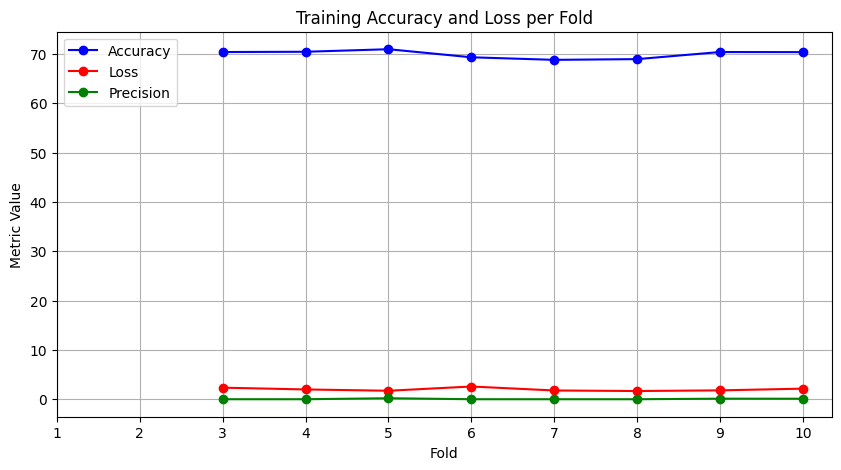

In [36]:
import matplotlib.pyplot as plt

# Plot training accuracy and loss per fold in the same figure
plt.figure(figsize=(10, 5))

# Plot accuracy
plt.plot(kfold_list, mean_acc_per_fold, marker='o', linestyle='-', color='b', label='Accuracy')

# Plot loss
plt.plot(kfold_list, mean_loss_per_fold, marker='o', linestyle='-', color='r', label='Loss')

# plot precision
plt.plot(kfold_list, mean_precision_per_fold,marker='o', linestyle='-', color='g', label='Precision')

plt.title('Training Accuracy and Loss per Fold')
plt.xlabel('Fold')
plt.ylabel('Metric Value')
plt.xticks(range(1, num_folds + 1))
plt.grid(True)
plt.legend()
plt.show()


# Normal training


In [ ]:
test

In [ ]:

# Hiperparameters
batch_size = 1
no_epochs = 100
verbosity = 2 #1
# Define the K-fold Cross Validator
num_folds = fold_it
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation for prints
fold_no = 1

# Define the model architecture
model = Sequential()
# Convolutional block 1
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=(3, 3), padding='same'))
model.add(LeakyReLU(alpha=0.01))
# Convolutional block 2
model.add(BatchNormalization())
model.add(Conv2D(8, (3, 3), padding='same'))
model.add(LeakyReLU(alpha=0.01))
# Convolutional block 3
model.add(BatchNormalization())
model.add(Conv2D(8, (3, 3), padding='same'))
model.add(LeakyReLU(alpha=0.01))
# Convolutional block 4
model.add(BatchNormalization())
model.add(Conv2D(8, (3, 3), padding='same'))
model.add(LeakyReLU(alpha=0.01))

model.add(Flatten())

model.add(Dense(64))
model.add(LeakyReLU(alpha=0.01))
model.add(Dense(1, activation='sigmoid') )

# Compile the model
model.compile(optimizer='adam', 
            loss='binary_crossentropy', 
            metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.SpecificityAtSensitivity(sensitivity=1)])


# Generate a print
print('------------------------------------------------------------------------')
print(f'Training for fold {fold_no} ...')

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            min_delta=0.0001)

# Fit data to model
history = model.fit(X_train[train], y_train[train],
            batch_size=batch_size,
            epochs=no_epochs,
            verbose=verbosity,
            callbacks=[callback])

# Generate generalization metrics
scores = model.evaluate(X_train[test], y_train[test], verbose=0)
print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%; {model.metrics_names[2]}: {scores[2]}')
acc_per_fold.append(scores[1] * 100)
loss_per_fold.append(scores[0])
precision_per_fold.append(scores[2])

if(scores[1]*100 > 60):
    folder_path = f'd:/Sistema/Escritorio/Escritorio/Tesis/DAIC-WOZ/folds/{num_folds}-fold_11_04_2024/'
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    subfolder_path = folder_path + f'{fold_no}-{scores[1]*100}/'
    if not os.path.exists(subfolder_path):
        os.makedirs(subfolder_path)

    #model.save(f'{folder_path}fold_v5_{fold_no}_{scores[1]*100}.h5')
    model.save(subfolder_path + f'fold-{fold_no}.h5')  # Replace with your actual path
    df_to_save = new_df_train.iloc[train].copy()
    df_to_save.drop('Spectrogram',axis=1, inplace=True)
    df_to_save.to_csv(subfolder_path + f'train-data-fold-{fold_no}.csv', index=False)
# Increase fold number
fold_no = fold_no + 1

# Get means
kfold_list.append(num_folds)

with open(folder_path+'score.txt', 'w') as file:
    # Write 'hello' to the file
    file.write(f' accuracy: {mean_acc}. loss: {mean_loss}. precision: {mean_precision}')
# Plot training accuracy per fold
